In [1]:
import Bio
from Bio import SeqIO
import gffutils

In [2]:
dna_data = SeqIO.read("ecoli.fasta", "fasta")
dna_seq = str(dna_data.seq)
print(len(dna_seq))

4641652


Просто создание базы данных

In [3]:
db = gffutils.create_db('ecoli.gff3', 'ecoli.db', merge_strategy='merge', force=True)

In [4]:
import ORF
ORFs = ORF.ORF_finder(str(dna_data.seq), minlen = 0)

In [5]:
genes = [gen for gen in db.features_of_type('gene')]
print(len(genes))

4419


In [6]:
raw_ORFs_coords = set((orf.start, orf.stop) for orf in ORFs)
ORFs_coords = set()
for orf_c in raw_ORFs_coords:
    if orf_c[0] > orf_c[1]:
        ORFs_coords.add(
            (len(str(dna_data.seq)) - orf_c[0], len(str(dna_data.seq)) - orf_c[1]))
    else:
        ORFs_coords.add(orf_c)
genes_coords = set((gen.start, gen.stop) for gen in genes)
print(
    len(ORFs_coords), 
    len(genes_coords), 
    len(ORFs_coords - genes_coords), 
    len(genes_coords - ORFs_coords),
    sep='\n')


439899
4419
435669
189


In [7]:
ORF_not_genes = ORFs_coords - genes_coords

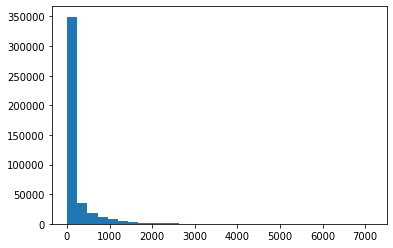

In [8]:
import matplotlib.pyplot as plt
plt.hist([coords[1] - coords[0] for coords in ORF_not_genes], bins=30)
plt.show()

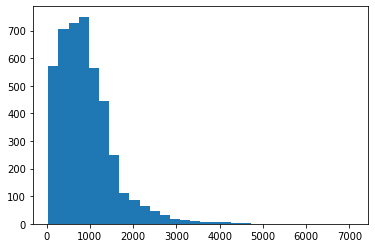

In [9]:
plt.hist([coords[1] - coords[0] for coords in genes_coords], bins=30)
plt.show()

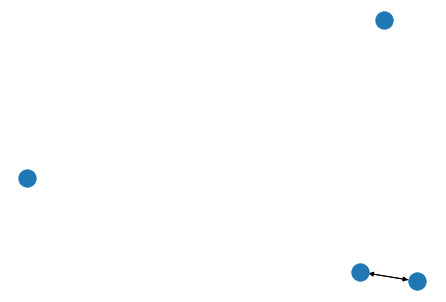

In [1]:
import pomegranate as pm
import numpy as np
from Bio import SeqIO

coding_probas = pm.DiscreteDistribution({'A' : 0.35, 'C' : 0.20, 'G' : 0.05, 'T' : 0.40})
non_coding_probas = pm.DiscreteDistribution({'A' : 0.10, 'C' : 0.40, 'G' : 0.40, 'T' : 0.10})

coding = pm.State(coding_probas, name='coding')
non_coding = pm.State(non_coding_probas, name='non_coding')

model = pm.HiddenMarkovModel()
model.add_states([coding, non_coding])
model.add_transition(coding, non_coding, 0.7)
model.add_transition(non_coding, coding, 0.3)
model.bake()

dna = np.array(list(str(SeqIO.read("ecoli.fasta", "fasta").seq)))

model.fit([dna], algorithm='viterbi')
model.plot()
#print(model.predict(dna))